In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv('../data/carclaims.csv')

In [2]:
# Drop ID-like or redundant columns
df = df.drop(['PolicyNumber', 'RepNumber', 'Year'], axis=1)

# Separate features and target
X = df.drop('FraudFound', axis=1)
y = df['FraudFound']
# map output to 0 and 1
y = y.map({'No': 0, 'Yes': 1})

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [3]:
# Identify categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# One-hot encoder
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ],
    remainder='passthrough'  # Keep numerical columns as is
)

# Fit and transform
X_train_encoded = preprocessor.fit_transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

# train XGBoost Model

In [4]:
# Handle class imbalance
scale_weight = (y_train == 0).sum() / (y_train == 1).sum()
# Initialize model with balanced class weights
model = xgb.XGBClassifier(
    scale_pos_weight=scale_weight,
    eval_metric='logloss',
    random_state=42
)

# Train model
model.fit(X_train_encoded, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

# Evaluate the model

              precision    recall  f1-score   support

           0       0.95      0.89      0.92      2899
           1       0.16      0.35      0.22       185

    accuracy                           0.85      3084
   macro avg       0.56      0.62      0.57      3084
weighted avg       0.91      0.85      0.88      3084



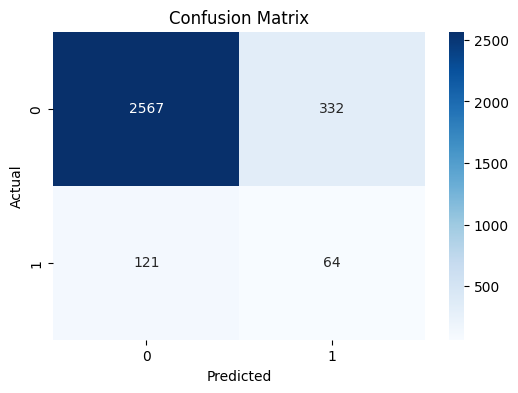

AUC-ROC Score: 0.7907


In [5]:
# Predictions
y_pred = model.predict(X_test_encoded)
y_proba = model.predict_proba(X_test_encoded)[:, 1]

# Classification Report
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# AUC-ROC Score
auc = roc_auc_score(y_test, y_proba)
print(f"AUC-ROC Score: {auc:.4f}")

# Hyperparameter tuning

In [6]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
import numpy as np

# hyperparameters
param_dist = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.5],
    'scale_pos_weight': [scale_weight]  # keep your class weight
}

# setup cross validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [7]:
# setup randomized search
random_search = RandomizedSearchCV(
    estimator=xgb.XGBClassifier(
        eval_metric='logloss',
        random_state=42
    ),
    param_distributions=param_dist,
    n_iter=20,  # Number of random combinations to try
    scoring='roc_auc',
    cv=cv,
    verbose=2,
    n_jobs=-1
)

In [8]:
# fit random search
random_search.fit(X_train_encoded, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None,
                                           feature_weights=None, gamma=None...
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.7, 0.8, 0.9,
                                                             1.0],
                                        'gamma': [0, 0.1, 0.2, 0.5],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 5, 7, 10],
                                        'n_estimators': [100, 300, 500],
                                        'scale_pos_weight': [np.float64(15.715447154471544)],
                                        'subsample': [0.7, 0.8, 0.9, 1.0]},
                   scoring='roc_auc', verbose=2)

In [9]:
# view best parameters
print("Best Parameters:", random_search.best_params_)
print(f"Best CV AUC Score: {random_search.best_score_:.4f}")

Best Parameters: {'subsample': 0.7, 'scale_pos_weight': np.float64(15.715447154471544), 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.7}
Best CV AUC Score: 0.8260


# Evaluate on Test Set

              precision    recall  f1-score   support

           0       0.99      0.60      0.75      2899
           1       0.13      0.92      0.23       185

    accuracy                           0.62      3084
   macro avg       0.56      0.76      0.49      3084
weighted avg       0.94      0.62      0.72      3084



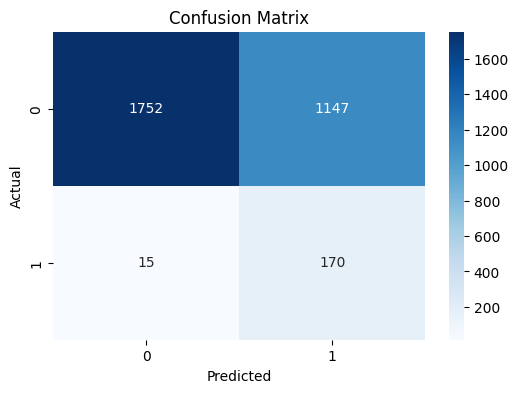

Test AUC-ROC Score: 0.8303


In [10]:
best_model = random_search.best_estimator_

y_pred = best_model.predict(X_test_encoded)
y_proba = best_model.predict_proba(X_test_encoded)[:, 1]

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

auc = roc_auc_score(y_test, y_proba)
print(f"Test AUC-ROC Score: {auc:.4f}")

#  Apply SMOTE for Class Imbalance

In [11]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to training data
smote = SMOTE(random_state=42)

X_train_balanced, y_train_balanced = smote.fit_resample(X_train_encoded, y_train)

print(f"Original training set shape: {X_train_encoded.shape}")
print(f"Balanced training set shape: {X_train_balanced.shape}")
print(f"Class distribution after SMOTE: {np.bincount(y_train_balanced)}")


Original training set shape: (12336, 145)
Balanced training set shape: (23196, 145)
Class distribution after SMOTE: [11598 11598]


# Retrain XGBoost on Balanced Data

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2899
           1       0.54      0.08      0.14       185

    accuracy                           0.94      3084
   macro avg       0.74      0.54      0.56      3084
weighted avg       0.92      0.94      0.92      3084



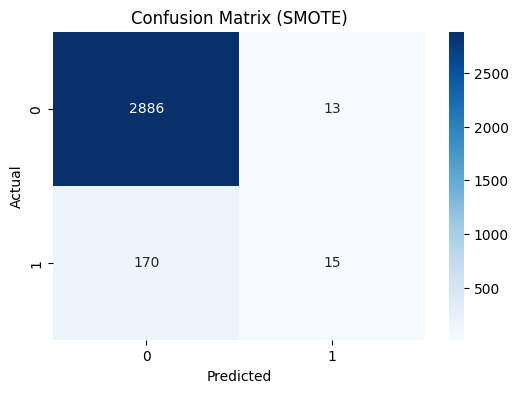

Test AUC-ROC Score (SMOTE): 0.8163


In [13]:
# Train a new model without scale_pos_weight
model_smote = xgb.XGBClassifier(
    eval_metric='logloss',
    random_state=42
)

model_smote.fit(X_train_balanced, y_train_balanced)

# evaluate
y_pred_smote = model_smote.predict(X_test_encoded)
y_proba_smote = model_smote.predict_proba(X_test_encoded)[:, 1]

print(classification_report(y_test, y_pred_smote))

cm_smote = confusion_matrix(y_test, y_pred_smote)
plt.figure(figsize=(6,4))
sns.heatmap(cm_smote, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (SMOTE)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

auc_smote = roc_auc_score(y_test, y_proba_smote)
print(f"Test AUC-ROC Score (SMOTE): {auc_smote:.4f}")